In [14]:
import pandas as pd

bioasq = pd.read_json("cache/BioASQ-training13b/training13b.json")
# bioasq.head()

In [ ]:
bioasq_old = pd.read_json('cache/BioASQ-training13b/training12b.json')
questions_old = bioasq_old['questions'].map(lambda entry: entry['body'])

In [ ]:
entries_old  = list(bioasq_old['questions'].values)
all_entries = list(bioasq['questions'].values)
# old_entries_set = set(entries_old)
# all_entries_set = set(all_entries)
# diff_entries = all_entries_set - old_entries_set

In [ ]:
all_bioasq_questions = bioasq['questions'].map(lambda entry: entry['body'])
all_bioasq_questions
new_question_set = set(all_bioasq_questions)
old_question_set = set(questions_old)
diff = new_question_set - old_question_set      # or new_question_set.difference(old_question_set)

# If you want the result back as a list:
diff_list = list(diff)
# diff_list

In [ ]:
bioasq['body'] = all_bioasq_questions
bioasq['ideal_answer'] = bioasq['questions'].map(lambda entry: entry['ideal_answer'][0])
diff_qa_pair = bioasq[bioasq["body"].isin(diff_list)].copy()
diff_qa_pair.head()

In [ ]:
import numpy as np
diff_q = pd.DataFrame({'body': diff_qa_pair['body'].astype(str)})
diff_q["task_id"] = np.array(range(len(diff_q)))
diff_q.to_csv('cache/BioASQ_new_question_only.csv', index=False)


In [ ]:
diff_q

,body,task_id
5049,Concizumab is used for which diseases?,0
5050,What type of extracolonic tumors does the PMS2...,1
5051,Do stroke patients have a lower risk of Obstru...,2
5052,Should all babies diagnosed with spina bifida ...,3
5053,What is Oculopharyngeal Muscular Dystrophy (OP...,4
...,...,...
5384,What disease can be treated with Trofinetide?,335
5385,Which is the most reliable liquid biopsy techn...,336
5386,Where is the tumor of follicular infundibulum ...,337
5387,Mechanisms that explain irritable bowel syndrome.,338


In [ ]:
reports = []

for i in range(len(diff_q)):
    try:
        
        state = pd.read_json(f"cache/agent_cache/{i}_state.json")
        final_report = state.iloc[-1,:]["agent_states"]['message_thread'][-1]['content']
    except:
        final_report = ""
    reports.append(final_report)
    
    
references = list(diff_qa_pair["ideal_answer"].values)[:len(reports)]


        

In [ ]:

# %%
from dotenv import load_dotenv
load_dotenv('/home/hao/test/bioRAG/.env')

True

In [ ]:
# !pip install google-genai

In [ ]:
from google import genai

client = genai.Client()


def extract_short_answer(query, report):
    """
    Extracts a short answer (<=3 sentences) to a query from a given report using Google's Gemini.

    Args:
        query (str): The question to be answered.
        report (str): The text report to extract the answer from.

    Returns:
        str: A short answer (<=3 sentences) to the query, extracted from the report.
    """
    prompt = f"Query: {query}\nReport: {report}\nAnswer in <=3 sentences:"
    try:
        # Configure the model
        response = client.models.generate_content(
            model="gemini-2.0-flash", contents= f"Query: {query}\nReport: {report}\nProvide a short reponse, around one sentence, ANSWER ONLY:"
        )
        # print(response.text)

        return response.text.strip()
    except Exception as e:
        return f"Error: {e}"


In [ ]:
# new_reports = [extract_short_answer(diff_qa_pair['body'].values[i] , reports[i]) for i in range(len(reports))]

In [ ]:
# pd.DataFrame({"new_reports": new_reports}).to_csv("cache/cleaned_reports1.csv")

NameError: name 'new_reports' is not defined

In [ ]:
# !pip install bert-score rouge Levenshtein

In [ ]:
new_reports = pd.read_csv("cache/cleaned_reports1.csv")

In [ ]:
# qa_metrics.py
"""Compute multiple QA evaluation metrics in a tidy API.

Input: two equal-length lists of strings (candidates, references)
Output: pandas.DataFrame with one row per QA pair and columns:
    - candidate, reference (original texts)
    - bert_p, bert_r, bert_f1
    - rouge1, rouge2, rougeL   (F1 scores)
    - levenshtein              (token‑level edit distance)

The module exposes a single public function:
    compute_metrics(candidates: list[str], references: list[str]) -> pd.DataFrame
"""
from __future__ import annotations

from typing import List

import pandas as pd
from bert_score import score as bert_score
from Levenshtein import distance as levenshtein_distance
from rouge import Rouge

def compute_metrics(candidates: List[str], references: List[str]) -> pd.DataFrame:  # noqa: D401
    """Return a DataFrame of evaluation metrics for each QA pair.

    Raises
    ------
    ValueError
        If *candidates* and *references* differ in length.
    """
    if len(candidates) != len(references):
        raise ValueError("candidates and references must have the same length")

    # BERTScore --------------------------------------------------------------
    P, R, F1 = bert_score([candidate.strip() for candidate in candidates], [reference.strip() for reference in references], lang="en", verbose=False)

    # ROUGE ------------------------------------------------------------------
    rouge = Rouge()
    rouge_scores = rouge.get_scores(candidates, references)  # list[dict]
    rouge1_f = [s["rouge-1"]["f"] for s in rouge_scores]
    rouge1_p = [s["rouge-1"]["p"] for s in rouge_scores]
    rouge1_r = [s["rouge-1"]["r"] for s in rouge_scores]
    rouge2_f = [s["rouge-2"]["f"] for s in rouge_scores]
    rouge2_p = [s["rouge-2"]["p"] for s in rouge_scores]
    rouge2_r = [s["rouge-2"]["r"] for s in rouge_scores]
    rougeL_f = [s["rouge-l"]["f"] for s in rouge_scores]
    rougeL_p = [s["rouge-l"]["p"] for s in rouge_scores]
    rougeL_r = [s["rouge-l"]["r"] for s in rouge_scores]

    # Levenshtein (token-level) ---------------------------------------------
    lev_dists = [
        levenshtein_distance(hyp.split(), ref.split())
        for hyp, ref in zip(candidates, references, strict=True)
    ]

    return pd.DataFrame(
        {
            "candidate": candidates,
            "reference": references,
            "bert_p": [float(x) for x in P],
            "bert_r": [float(x) for x in R],
            "bert_f1": [float(x) for x in F1],
            "rouge1_f": rouge1_f,
            "rouge1_p": rouge1_p,
            "rouge1_r": rouge1_r,
            "rouge2_f": rouge2_f,
            "rouge2_p": rouge2_p,
            "rouge2_r": rouge2_r,
            "rougeL_f": rougeL_f,
            "rougeL_p": rougeL_p,
            "rougeL_r": rougeL_r,
            "levenshtein": lev_dists,
        }
    )

/home/hao/anaconda3/envs/bioagents/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = compute_metrics(reports, references)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd
from IPython.display import display, Latex

# Convert the DataFrame to LaTeX
# latex_table = df.to_latex(index=False, escape=False)

# df.head()

In [ ]:
from IPython.display import display, HTML


# Render the dataframe as HTML table
# display(HTML(df.to_html(index=False)))

In [ ]:
type(references)

list

In [ ]:


df = compute_metrics(new_reports, references)
print(df.head())


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                           candidate  \
0  Concizumab is used to treat hemophilia A or B ...   
1  Monoallelic PMS2 germline mutations, associate...   
2  No, stroke patients do not have a lower risk o...   
3  For babies with open spina bifida requiring po...   
4  Oculopharyngeal Muscular Dystrophy (OPMD) is a...   

                                           reference    bert_p    bert_r  \
0    Concizumab is developed for hemophilia A and B.  0.848759  0.959675   
1  The PMS2 gene is one of the mismatch repair ge...  0.873931  0.848565   
2  There are no studies suggesting that stroke pa...  0.875455  0.929762   
3  No, not all babies diagnosed with spina bifida...  0.903096  0.843710   
4  oculopharyngeal muscular dystrophy (OPMD) is a...  0.888055  0.915718   

    bert_f1  rouge1_f  rouge1_p  rouge1_r  rouge2_f  rouge2_p  rouge2_r  \
0  0.900816  0.325581  0.200000  0.875000  0.083333  0.048780  0.285714   
1  0.861062  0.323529  0.523810  0.234043  0.087912  0.1

means
bert_p          0.875679
bert_r          0.896090
bert_f1         0.885206
rouge1_f        0.302602
rouge1_p        0.292467
rouge1_r        0.408777
rouge2_f        0.119557
rouge2_p        0.114408
rouge2_r        0.174880
rougeL_f        0.270283
rougeL_p        0.259388
rougeL_r        0.368104
levenshtein    52.711765
dtype: float64


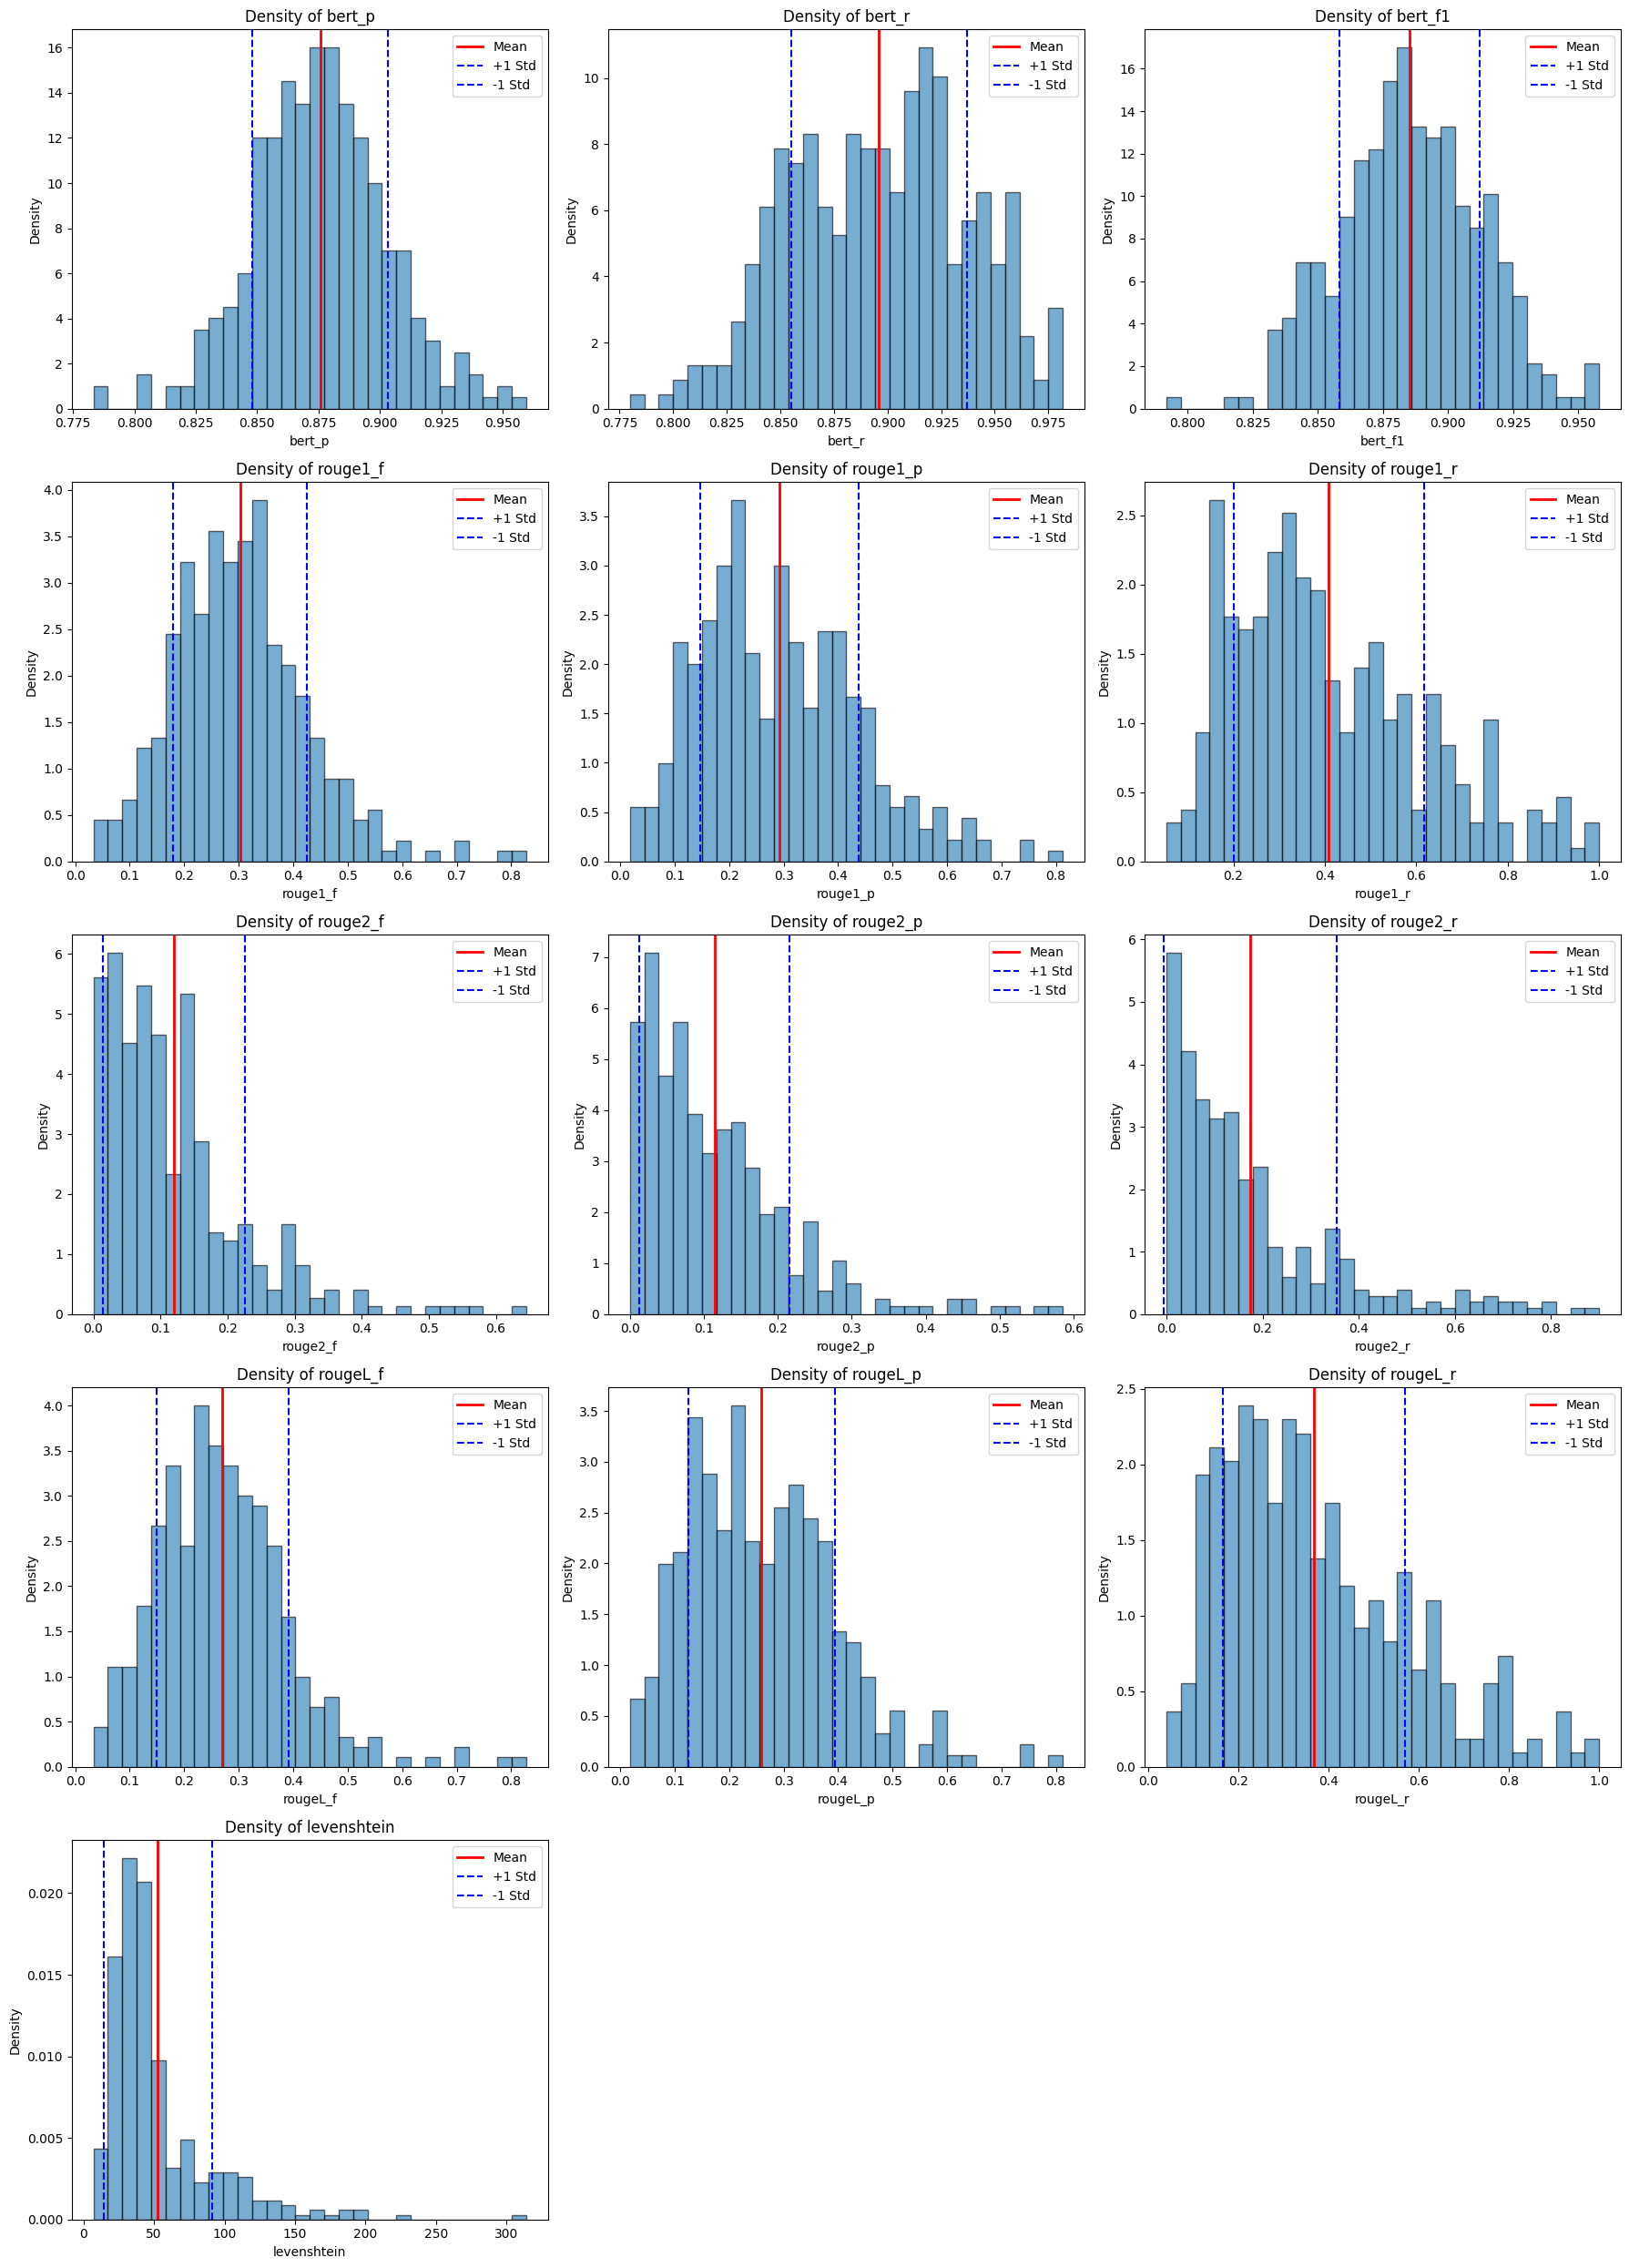

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Example dataframe
# df = pd.read_csv('your_file.csv')  # or however your df is defined

# Reset the index to ignore row names
df = df.reset_index(drop=True)

# Select only numerical columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Compute means and standard deviations
means = df[numeric_cols].mean()
stds = df[numeric_cols].std()
print('means')
print(means)
# Set up the figure
num_cols = len(numeric_cols)
num_rows = (num_cols + 2) // 3  # adjust for 3 plots per row
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

# Plot each numeric column
for idx, column in enumerate(numeric_cols):
    ax = axes[idx]
    ax.hist(df[column].dropna(), bins=30, edgecolor='k', density=True, alpha=0.6)

    # Plot mean
    ax.axvline(means[column], color='red', linestyle='solid', linewidth=2, label='Mean')
    
    # Plot mean ± 1 standard deviation
    ax.axvline(means[column] + stds[column], color='blue', linestyle='dashed', linewidth=1.5, label='+1 Std')
    ax.axvline(means[column] - stds[column], color='blue', linestyle='dashed', linewidth=1.5, label='-1 Std')
    
    ax.set_title(f'Density of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

    ax.legend()

# Hide any unused subplots
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from IPython.display import display, Latex

# Create a new DataFrame
mean_df = pd.DataFrame(means, columns=['Average'])

mean_df_transposed = mean_df.transpose()
# Generate LaTeX code
latex_code = pd.DataFrame(mean_df_transposed[["bert_f1", "bert_p", "bert_r",  "rouge1_p", "rouge2_p", "levenshtein"]]).to_latex()

print(latex_code)


\begin{tabular}{lrrrrrr}
\toprule
 & bert_f1 & bert_p & bert_r & rouge1_p & rouge2_p & levenshtein \\
\midrule
Average & 0.885206 & 0.875679 & 0.896090 & 0.292467 & 0.114408 & 52.711765 \\
\bottomrule
\end{tabular}



In [ ]:
latex_code = mean_df_transposed.to_latex()

print(latex_code)

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
 & bert_p & bert_r & bert_f1 & rouge1_f & rouge1_p & rouge1_r & rouge2_f & rouge2_p & rouge2_r & rougeL_f & rougeL_p & rougeL_r & levenshtein \\
\midrule
Average & 0.875679 & 0.896090 & 0.885206 & 0.302602 & 0.292467 & 0.408777 & 0.119557 & 0.114408 & 0.174880 & 0.270283 & 0.259388 & 0.368104 & 52.711765 \\
\bottomrule
\end{tabular}

